In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from sklearn.decomposition import PCA
import seaborn as sns
from keras.optimizers import Adam
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.models import load_model

from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [2]:
def change_number(unique_lst):
    unique = pd.DataFrame(unique_lst).reset_index()
    indexes = unique['index']
    ids = unique[0]
    tuple_zip = list(zip(ids, indexes))
    dic = dict((x, y) for x, y in tuple_zip)
    reverse_dic = dict((y, x) for x, y in tuple_zip)
    return dic, reverse_dic

In [3]:
ratings = pd.read_csv('result_dessertMF.csv')

In [4]:
unique_users = list(ratings['user_id'].unique())
unique_recipe = list(ratings['recipe_id'].unique())

In [5]:
dic_user, dummy = change_number(unique_users)

ratings['user_id'] = ratings['user_id'].replace(dic_user)
                                                

In [6]:
dic_recipe, dic_recipe_reverse = change_number(unique_recipe)

ratings['recipe_id'] = ratings['recipe_id'].replace(dic_recipe)

### Scale 

In [7]:
scaler = MinMaxScaler()
ratings['rating'] = ratings['rating'].values.astype(float)
rating_scaled = pd.DataFrame(scaler.fit_transform(ratings['rating'].values.reshape(-1,1)))
ratings['rating'] = rating_scaled

### Train test split 

In [8]:
train, test = train_test_split(ratings, test_size=0.2)

In [9]:
n_users = ratings.user_id.nunique()
n_recipe = ratings.recipe_id.nunique()

### Make model

In [10]:
n_latent_factors_user = 20
n_latent_factors_recipe = 20

recipe_input = keras.layers.Input(shape=[1],name='Recipe')
recipe_embedding = keras.layers.Embedding(n_recipe + 1, n_latent_factors_recipe, name='Recipe-Embedding')(recipe_input)
recipe_vec = keras.layers.Flatten(name='Flatten-Recipes')(recipe_embedding)
recipe_vec = keras.layers.Dropout(0.2)(recipe_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = Embedding(n_users+1, n_latent_factors_user, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)
user_vec = keras.layers.Flatten(name='Flatten-Users')(user_embedding)
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.concatenate([recipe_vec, user_vec], axis=1, name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200, name='FullyConnected', activation='relu')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100, name='FullyConnected-1', activation='relu')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50, name='FullyConnected-2', activation='relu')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20, name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, recipe_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

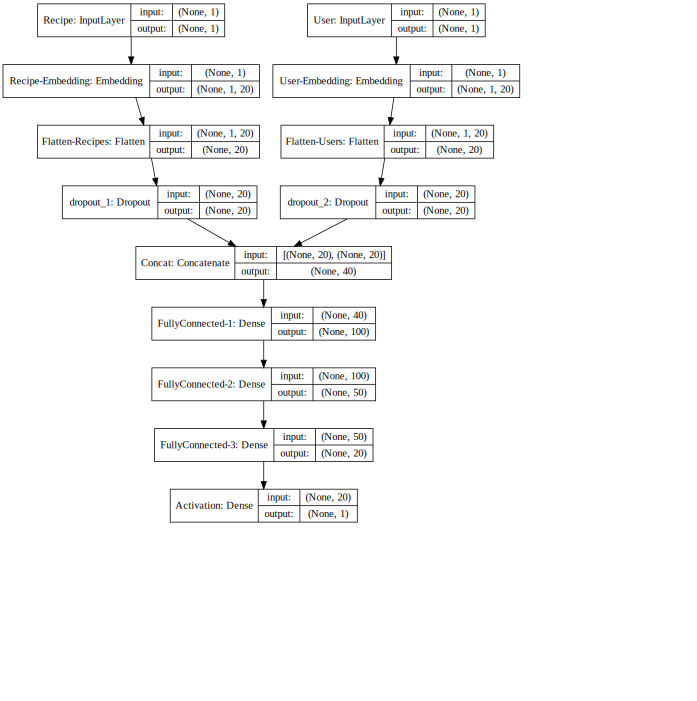

In [11]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [12]:
history = model.fit([train.user_id, train.recipe_id], train.rating, epochs=100, verbose=1)
model.save('NN_Dessert3.h5')

/Users/louise/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
36278/36278 [==============================] - 3s 82us/step - loss: 0.0821
Epoch 2/100
36278/36278 [==============================] - 2s 67us/step - loss: 0.0711
Epoch 3/100
36278/36278 [==============================] - 2s 67us/step - loss: 0.0692
Epoch 4/100
36278/36278 [==============================] - 2s 68us/step - loss: 0.0673
Epoch 5/100
36278/36278 [==============================] - 2s 67us/step - loss: 0.0649
Epoch 6/100
36278/36278 [==============================] - 2s 69us/step - loss: 0.0621
Epoch 7/100
36278/36278 [==============================] - 3s 73us/step - loss: 0.0617
Epoch 8/100
36278/36278 [==============================] - 3s 72us/step - loss: 0.0606
Epoch 9/100
36278/36278 [==============================] - 2s 66us/step - loss: 0.0592
Epoch 10/100
36278/36278 [==============================] - 2s 66us/step - loss: 0.0586
Epoch 11/100
36278/36278 [==============================] - 2s 67us/step - loss: 0.0577
Epoch 12/100
36278/36278 [===============

36278/36278 [==============================] - 3s 70us/step - loss: 0.0504
Epoch 94/100
36278/36278 [==============================] - 3s 72us/step - loss: 0.0500
Epoch 95/100
36278/36278 [==============================] - 3s 90us/step - loss: 0.0497
Epoch 96/100
36278/36278 [==============================] - 3s 95us/step - loss: 0.0490
Epoch 97/100
36278/36278 [==============================] - 3s 96us/step - loss: 0.0491
Epoch 98/100
36278/36278 [==============================] - 4s 108us/step - loss: 0.0493
Epoch 99/100
36278/36278 [==============================] - 3s 78us/step - loss: 0.0488
Epoch 100/100
36278/36278 [==============================] - 3s 80us/step - loss: 0.0488


Text(0, 0.5, 'Train Error')

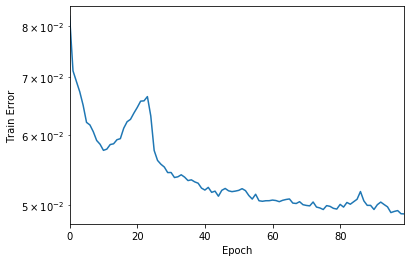

In [13]:
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

In [14]:
y_hat = np.round(model.predict([test.user_id, test.recipe_id]),0)
y_true = test.rating

MAE = mean_absolute_error(y_true, y_hat)

percentage_wrong = MAE/1 * 100
percentage_wrong


6.615214994487322

In [ ]:
#MAE met 35 epochs 0.07167362901075459
# met 100 7.0694597574421145
# 

In [15]:
def recommendation(ratings):
    recipe_ids = ratings.recipe_id.unique()
    user = np.array([1 for i in range(len(recipe_ids))])

    predictions = model.predict([user, recipe_ids])
    predictions = np.array([a[0] for a in predictions])
    recommended_recipe_ids = (-predictions).argsort()[:50]
    
    return list(zip(recommended_recipe_ids, predictions[recommended_recipe_ids]))

In [17]:
recommendations = recommendation(ratings)

recommendations

[(0, 1.0034128),
 (5515, 1.0034128),
 (5514, 1.0034128),
 (5513, 1.0034128),
 (5512, 1.0034128),
 (5511, 1.0034128),
 (5510, 1.0034128),
 (5509, 1.0034128),
 (5508, 1.0034128),
 (5505, 1.0034128),
 (5504, 1.0034128),
 (5503, 1.0034128),
 (5502, 1.0034128),
 (5499, 1.0034128),
 (5498, 1.0034128),
 (5497, 1.0034128),
 (5496, 1.0034128),
 (5495, 1.0034128),
 (5494, 1.0034128),
 (5493, 1.0034128),
 (5492, 1.0034128),
 (5491, 1.0034128),
 (5490, 1.0034128),
 (5489, 1.0034128),
 (5488, 1.0034128),
 (5487, 1.0034128),
 (5485, 1.0034128),
 (5484, 1.0034128),
 (5516, 1.0034128),
 (5483, 1.0034128),
 (5517, 1.0034128),
 (5519, 1.0034128),
 (5553, 1.0034128),
 (5552, 1.0034128),
 (5551, 1.0034128),
 (5550, 1.0034128),
 (5549, 1.0034128),
 (5547, 1.0034128),
 (5546, 1.0034128),
 (5544, 1.0034128),
 (5543, 1.0034128),
 (5542, 1.0034128),
 (5541, 1.0034128),
 (5540, 1.0034128),
 (5538, 1.0034128),
 (5537, 1.0034128),
 (5536, 1.0034128),
 (5535, 1.0034128),
 (5533, 1.0034128),
 (5531, 1.0034128)]